### Download the dataset from Kaggle:

Credits:
Taxi Routes of Mexico City, Quito and more
Mario Navas
https://www.kaggle.com/datasets/mnavas/taxi-routes-for-mexico-city-and-quito/data


In [30]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [32]:
!pip install -q kaggle


In [33]:
!kaggle datasets download -d mnavas/taxi-routes-for-mexico-city-and-quito


Dataset URL: https://www.kaggle.com/datasets/mnavas/taxi-routes-for-mexico-city-and-quito
License(s): CC-BY-SA-4.0
taxi-routes-for-mexico-city-and-quito.zip: Skipping, found more recently modified local copy (use --force to force download)


In [34]:
!unzip taxi-routes-for-mexico-city-and-quito.zip


Archive:  taxi-routes-for-mexico-city-and-quito.zip
replace all-data_clean.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# Import the dataset in pandas

In [35]:
import pandas as pd
df = pd.read_csv('mex_clean.csv')

In [36]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,dist_meters,wait_sec
0,1,México DF Taxi de Sitio,2016-09-16 07:14:12,2016-09-18 04:41:40,-99.097369,19.416874,-99.202729,19.430353,N,120449,12373,242
1,2,México DF Taxi Libre,2016-09-18 06:16:33,2016-09-18 10:11:43,-99.297148,19.322128,-99.289949,19.326538,N,14110,1700,461
2,3,México DF Taxi Libre,2016-09-18 10:11:50,2016-09-18 10:23:11,-99.289603,19.326263,-99.271874,19.328530,N,681,2848,129
3,4,México DF Taxi Libre,2016-09-18 10:23:38,2016-09-18 10:30:53,-99.271161,19.328875,-99.279900,19.326256,N,436,1409,106
4,5,México DF Taxi Libre,2016-09-18 10:44:18,2016-09-18 10:51:40,-99.282761,19.326944,-99.291705,19.322754,N,442,1567,85


In [37]:
df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration',
       'dist_meters', 'wait_sec'],
      dtype='object')

### First I am going to drop off the datetimes because a model for trip duration would be dropoff_datetime - dropoff_datetime

In [38]:
dataset = df.drop(['dropoff_datetime', 'pickup_datetime'], axis=1)

# Features engineering:




In [39]:

categorical_data =['id',	'vendor_id', 'store_and_fwd_flag']
y = ['trip_duration']
numerical_features = [ p for p in dataset.columns if p not in categorical_data + y]
numerical_features


['pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'dist_meters',
 'wait_sec']

### Achtung!
The two features dist_meters and wait sec are really spread out and plotting their histogram takes a lot of RAM. To avoid this we clip the 95% of the data and apply the $log$ trasformation.

## Wait_sec

Descriptive statistics for: wait_sec
count    1.269400e+04
mean     1.161270e+06
std      5.799612e+07
min      0.000000e+00
25%      8.900000e+01
50%      2.340000e+02
75%      5.910000e+02
max      4.429346e+09
Name: wait_sec, dtype: float64
Standard deviation: 57996115.6018533


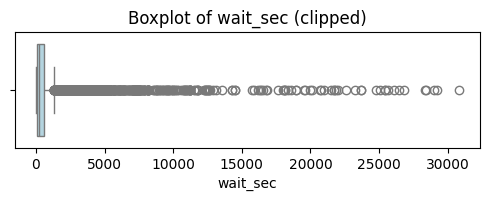

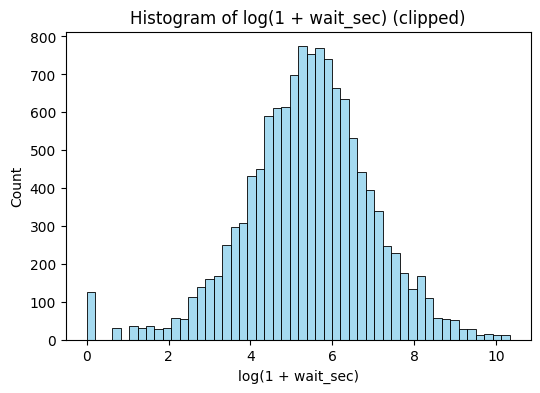

In [40]:
import seaborn as sns


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def safe_summary_plots(df, feature, clip_quantile=0.995):
    # Describe
    print(f"Descriptive statistics for: {feature}")
    print(df[feature].describe())
    print(f"Standard deviation: {df[feature].std()}")

    # Clip outliers for boxplot and histogram
    upper_clip = df[feature].quantile(clip_quantile)
    lower_clip = df[feature].quantile(1 - clip_quantile)
    clipped = df[(df[feature] >= lower_clip) & (df[feature] <= upper_clip)]

    # Boxplot
    plt.figure(figsize=(6, 1.5))
    sns.boxplot(x=clipped[feature], color='lightblue')
    plt.title(f'Boxplot of {feature} (clipped)')
    plt.show()

    # Histogram (optionally use log scale if highly skewed)
    plt.figure(figsize=(6, 4))
    log_feature = np.log1p(clipped[feature])
    sns.histplot(log_feature, bins=50, kde=False, color='skyblue')
    plt.title(f'Histogram of log(1 + {feature}) (clipped)')
    plt.xlabel(f'log(1 + {feature})')
    plt.show()



safe_summary_plots(dataset, 'wait_sec')

##### The distribution of log_wait_sec exhibits a bell-shaped curve, making it more suitable for normalization. Therefore, it will be used in place of wait_sec.

In [41]:
log_wait_sec = np.log1p(dataset['wait_sec'])
dataset['log_wait_sec'] = log_wait_sec
dataset = dataset.drop(['wait_sec'], axis=1)

## dist_meters

Descriptive statistics for: dist_meters
count     12694.000000
mean       6666.431700
std       11386.891512
min          21.000000
25%        1775.000000
50%        3948.000000
75%        8265.000000
max      802537.000000
Name: dist_meters, dtype: float64
Standard deviation: 11386.891511901407


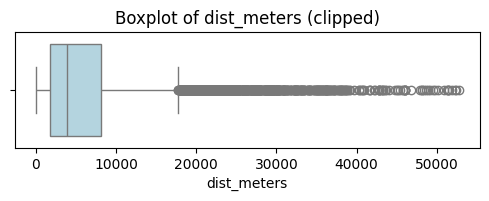

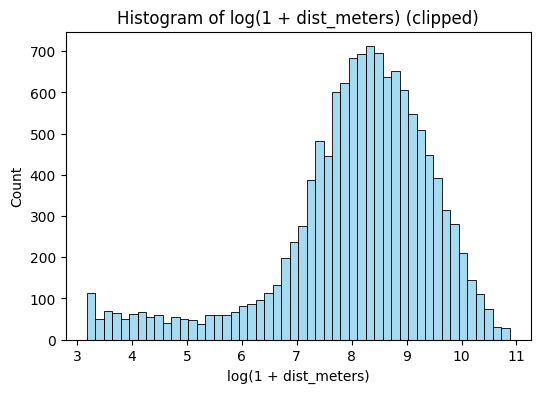

In [42]:
safe_summary_plots(dataset, 'dist_meters')

The distribution of $\log(1 + \text{dist_meters})$ is right-skewed with many outliers. Despite the long tail, there is a clear mode, and the data is concentrated around it. These characteristics suggest that $\log(1 + \text{dist_meters})$ is more appropriate for normalization. Therefore, I will replace the dist_meters feature with its log-transformed version.

In [43]:
log_dist_meters = np.log1p(dataset['dist_meters'])
dataset['log_dist_meters'] = log_dist_meters
dataset = dataset.drop(['dist_meters'], axis=1)

In [44]:
dataset = dataset.drop(['store_and_fwd_flag'], axis=1)

In [45]:
dataset = dataset.drop(['vendor_id'], axis=1)

## The Pick_Up Longitude

In [46]:
def raw_feature_summary(df, feature):
    # Descriptive statistics
    print(f"Descriptive statistics for: {feature}")
    print(df[feature].describe())
    print(f"Standard deviation: {df[feature].std()}\n")

    # Boxplot
    plt.figure(figsize=(6, 1.5))
    sns.boxplot(x=df[feature], color='lightblue')
    plt.title(f'Boxplot of {feature}')
    plt.show()

    # Histogram
    plt.figure(figsize=(6, 4))
    sns.histplot(df[feature], bins=50, kde=False, color='skyblue')
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

Descriptive statistics for: pickup_longitude
count    12694.000000
mean       -99.136155
std          0.430001
min       -108.985069
25%        -99.195615
50%        -99.164436
75%        -99.107092
max        -86.871347
Name: pickup_longitude, dtype: float64
Standard deviation: 0.4300007982342574



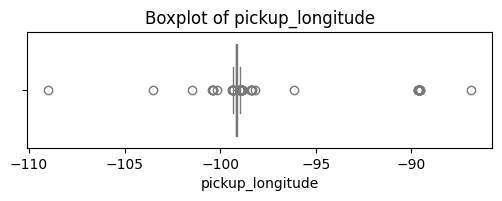

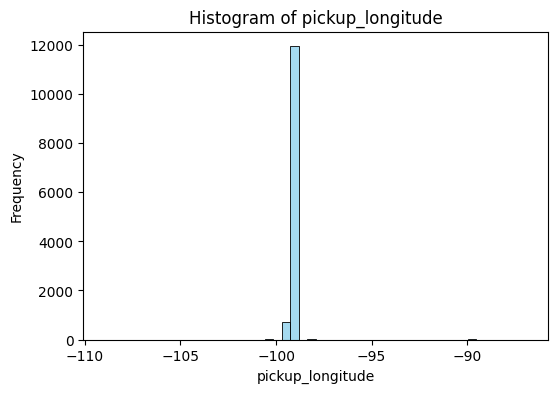

In [47]:
#'pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude
raw_feature_summary(dataset, 'pickup_longitude')

The pick up longitude is nearly uniform in the interval $0.0$ and $0.8$

## The Drop_off_Longitude

Descriptive statistics for: dropoff_longitude
count    12694.000000
mean       -99.133728
std          0.429582
min       -108.987429
25%        -99.192102
50%        -99.160705
75%        -99.107355
max        -86.871002
Name: dropoff_longitude, dtype: float64
Standard deviation: 0.42958163992090564



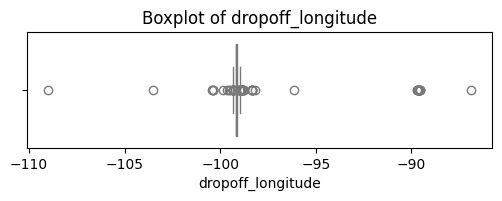

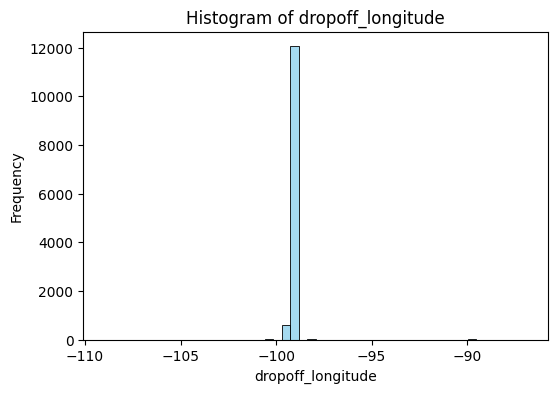

In [48]:
raw_feature_summary(dataset, 'dropoff_longitude')

The distribution of drop-off longitudes shows at least two modes, with values highly concentrated in a few locations and a number of clear outliers. This suggests trips tend to end in a few key zones. In contrast, absolute latitudes appear less informative with respect to trip duration. A more meaningful representation may be the difference between pickup and drop-off coordinates, such as delta_latitude and delta_longitude, which capture the spatial extent and direction of the trip.

## The pick up latitude

Descriptive statistics for: pickup_latitude
count    12694.000000
mean        19.385067
std          0.129518
min         18.829117
25%         19.325832
50%         19.371382
75%         19.432106
max         25.752964
Name: pickup_latitude, dtype: float64
Standard deviation: 0.12951797852274738



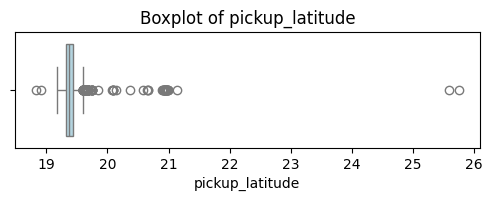

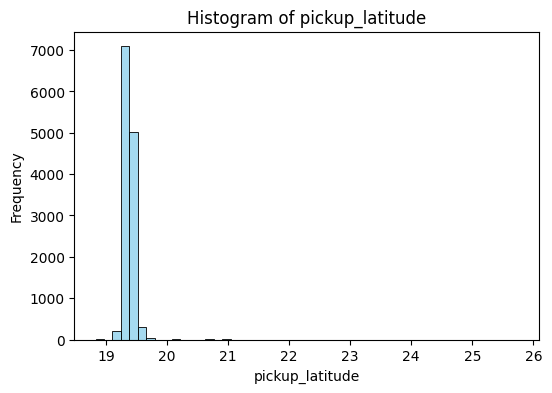

In [49]:
raw_feature_summary(dataset, 'pickup_latitude')

Again the pick up latitude is uniform between $0.0$ and $0.8.$

## The drop off latitude


Descriptive statistics for: dropoff_latitude
count    12694.000000
mean        19.386764
std          0.131199
min         18.829103
25%         19.325325
50%         19.374913
75%         19.434360
max         25.781058
Name: dropoff_latitude, dtype: float64
Standard deviation: 0.13119871003659653



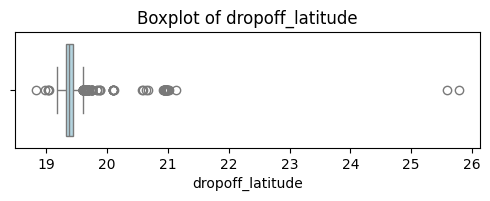

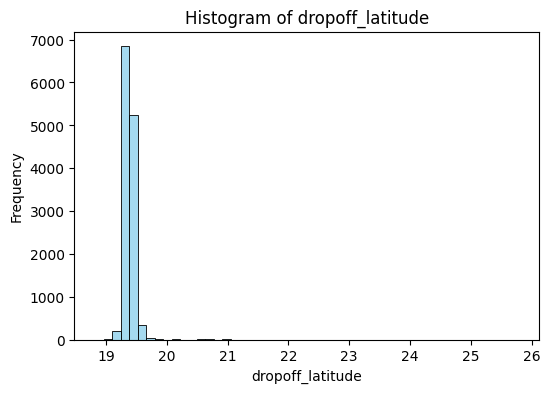

In [50]:
raw_feature_summary(dataset, 'dropoff_latitude')

The situation is similar to the drop off longitude

Since the raw latitude and longitude values are highly concentrated around a few key locations, they behave more like categorical variables than informative continuous ones. Therefore, in this initial regression attempt, I will exclude them and focus on more directly meaningful features.

In [51]:
dataset = dataset.drop(['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'], axis=1)

In [52]:
x = dataset.drop(['id', 'trip_duration'], axis=1)
y = dataset['trip_duration']

## Normalization

The two remaining features, log_wait and log_dist, are now well-conditioned for standardization using a StandardScaler. After applying this transformation, I will create both 2D and 3D scatter plots to visually assess how these features relate to the target variable, trip_duration. This exploration will also help evaluate whether a linear model is likely to capture the underlying structure of the data and how much of the variance in trip_duration might be explained by these inputs.

In [53]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(x)
y = dataset['trip_duration'].values  # leave y as-is

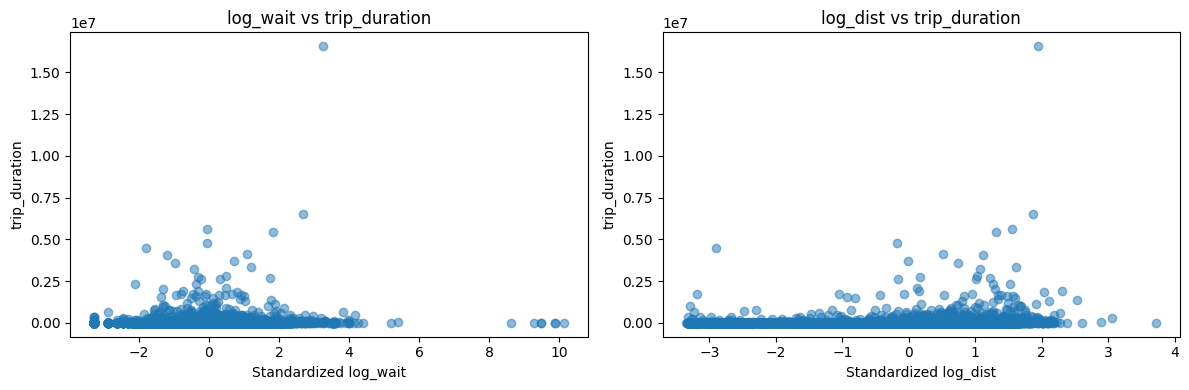

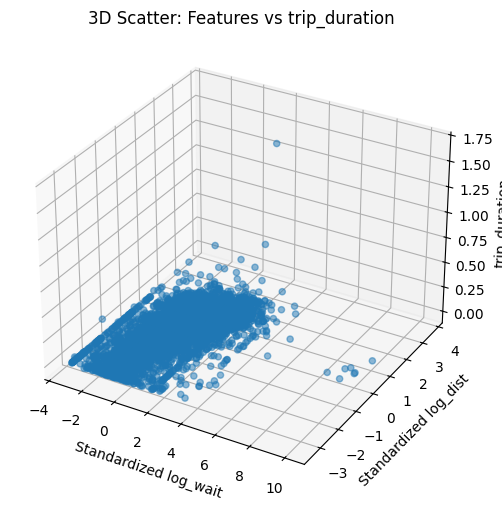

In [54]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 2D Scatter plots of each feature vs. target
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.scatter(X_scaled[:, 0], y, alpha=0.5)
plt.xlabel('Standardized log_wait')
plt.ylabel('trip_duration')
plt.title('log_wait vs trip_duration')

plt.subplot(1, 2, 2)
plt.scatter(X_scaled[:, 1], y, alpha=0.5)
plt.xlabel('Standardized log_dist')
plt.ylabel('trip_duration')
plt.title('log_dist vs trip_duration')

plt.tight_layout()
plt.show()

# 3D Scatter plot: (log_wait, log_dist, trip_duration)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_scaled[:, 0], X_scaled[:, 1], y, alpha=0.5)
ax.set_xlabel('Standardized log_wait')
ax.set_ylabel('Standardized log_dist')
ax.set_zlabel('trip_duration')
ax.set_title('3D Scatter: Features vs trip_duration')
plt.show()



In [55]:
import plotly.graph_objects as go
import pandas as pd

fig = go.Figure(data=[go.Scatter3d(
    x=X_scaled[:, 0],
    y=X_scaled[:, 1],
    z=y,
    mode='markers',
    marker=dict(
        size=3,
        color=y,  # could use another variable for color
        colorscale='Viridis',
        opacity=0.6
    )
)])

fig.update_layout(
    scene=dict(
        xaxis_title='Standardized log_wait',
        yaxis_title='Standardized log_dist',
        zaxis_title='trip_duration'
    ),
    title='Interactive 3D Scatter Plot',
    margin=dict(l=0, r=0, b=0, t=30)
)

fig.show()


# Unfortunately, the features selected are the uncorrelted with each other, the scatterplots are mostly flat.


### Maybe I should subdivide the datasets between cities, learn to run linear regression with categorical data. Lastly try to convert everything to a number and squash it into a goddam neural net with two layers, it will figure something out!!

### Correlations among the features



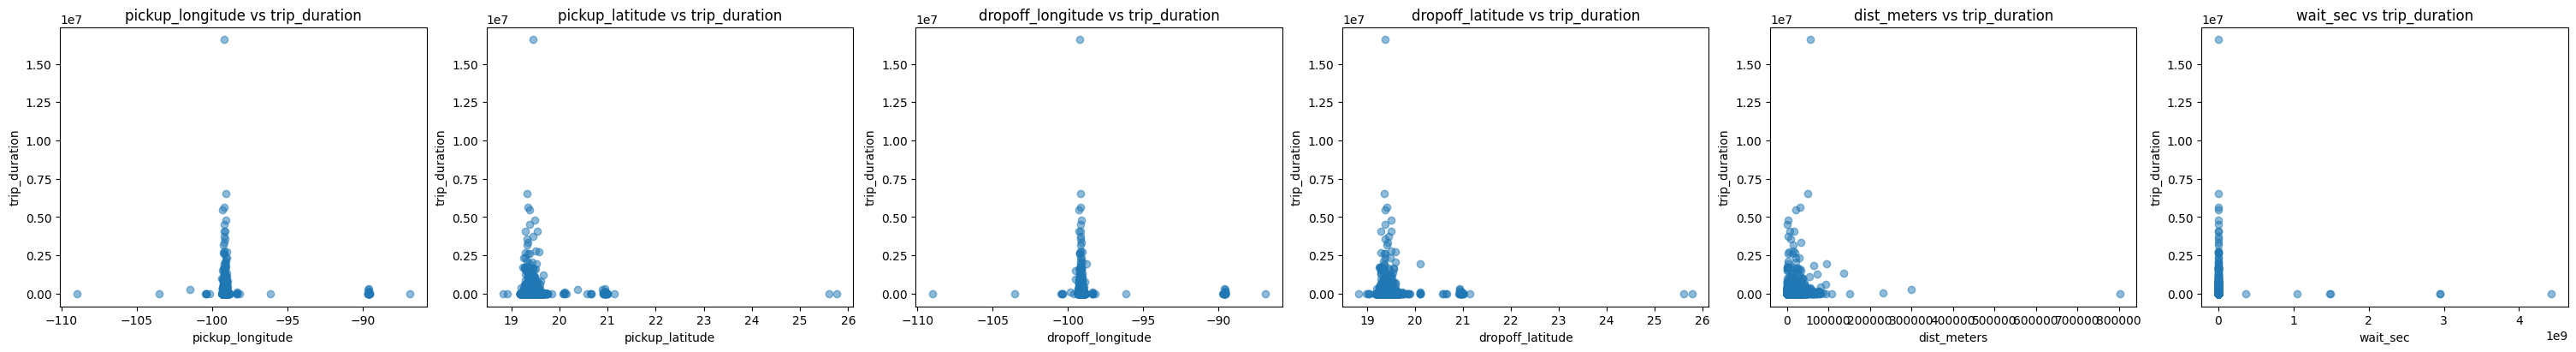

In [56]:
import matplotlib.pyplot as plt

# Features to compare with trip_duration


# Setup subplots
n = len(numerical_features)
fig, axes = plt.subplots(1, n, figsize=(5 * n, 4), constrained_layout=True)

# Create scatter plots
for i, feature in enumerate(numerical_features):
    axes[i].scatter(df[feature], dataset['trip_duration'], alpha=0.5)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('trip_duration')
    axes[i].set_title(f'{feature} vs trip_duration')

plt.show()

